# Chargement des packages

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tools.eval_measures import rmse

import pmdarima as pm

# Chemins

In [20]:
repertoire_data = os.getcwd() + '\\Data\\'
fichier_rte_meteo = 'rte_meteo_max_hebdo.csv'

# Lecture et analyse du fichier rte_meteo

In [21]:
os.chdir(repertoire_data)
df_rte = pd.read_csv(
    fichier_rte_meteo, 
    sep=';', 
    index_col='Date',
    parse_dates=['Date'],
)

In [22]:
print(df_rte.info())
df_rte.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2015-01-04 to 2019-12-29
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Consommation (MW)       262 non-null    int64  
 1   Thermique (MW)          262 non-null    int64  
 2   Nucléaire (MW)          262 non-null    int64  
 3   Eolien (MW)             262 non-null    int64  
 4   Solaire (MW)            262 non-null    int64  
 5   Hydraulique (MW)        262 non-null    int64  
 6   Pompage (MW)            262 non-null    int64  
 7   Bioénergies (MW)        262 non-null    int64  
 8   Ech. physiques (MW)     262 non-null    int64  
 9   Production totale (MW)  262 non-null    int64  
 10  temp                    262 non-null    float64
 11  humidite                262 non-null    float64
 12  nebulosite              262 non-null    float64
 13  rafale_periode          262 non-null    float64
 14  vitesse_vent           

,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),Production totale (MW),...,humidite,nebulosite,rafale_periode,vitesse_vent,pluie_3h,pluie_6h,pluie_12h,pluie_24h,year,week
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-04,75334,5802,58730,1659,0,13493,-57,892,-5184,80519,...,83.130632,86.585130,5.620076,3.219856,1.869231,3.869231,7.138462,8.700000,2015,1
2015-01-11,83939,10748,60182,1686,0,14494,-4,863,-4034,87969,...,87.408413,87.248908,4.625960,2.574724,0.600000,1.253846,2.092308,2.538462,2015,2
2015-01-18,77277,5515,59712,6353,0,13682,-10,953,-8923,86205,...,74.160920,82.019746,8.794203,5.082143,0.784615,1.607692,2.530769,14.484615,2015,3
2015-01-25,86687,11092,60563,1394,0,14959,-10,899,-2208,88897,...,84.561401,77.519265,5.002026,2.746277,1.753846,5.184615,21.038462,68.330769,2015,4
2015-02-01,82818,10656,59867,3226,0,13660,-4,950,-5534,88355,...,82.479876,93.811023,6.306525,3.781490,5.261538,10.015385,16.038462,18.700000,2015,5


1. Vérifier la stationnarité du modèle.
2. Estimation du paramètre d si la série est non-stationnaire.
3. Estimation du paramètre D si la série différenciée est non-stationnaire.
4. Trouver les paramètres p q, P et Q qui définissent le modèle de la série.

## Création d'un df consommation nationale
*Dans cette nouvelle version du code, le fichier df_rte_max en entrée est déjà au niveau national.*

In [23]:
conso_nationale_hebdo = df_rte

# Série temporelle : maille hebdo
*Application d'un mean sur le groupby car sinon les semaines 53 sont sous-représentées (moins de jours ces semaines-là).*

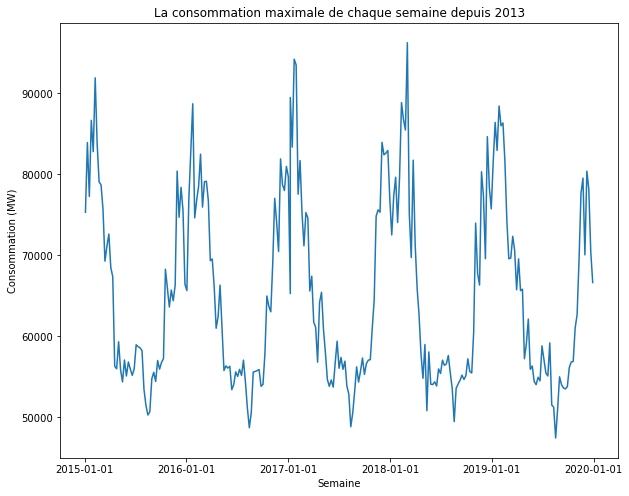

In [24]:
# Graphique
plt.figure(figsize=(10, 8))
plt.plot(conso_nationale_hebdo.index, conso_nationale_hebdo['Consommation (MW)']);
plt.title('La consommation maximale de chaque semaine depuis 2013')
plt.xlabel('Semaine')
plt.ylabel('Consommation (MW)')
plt.xticks(['2015-01', '2016-01', '2017-01', '2018-01', '2019-01', '2020-01']);

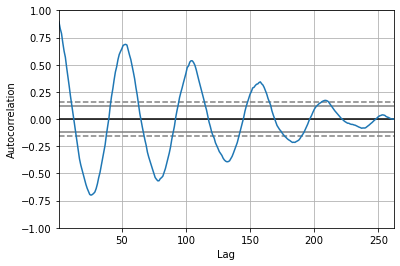

In [25]:
pd.plotting.autocorrelation_plot(conso_nationale_hebdo['Consommation (MW)']);

Le corrélogramme décroit lentement vers 0, on va différencier pour rendre stationnaire.

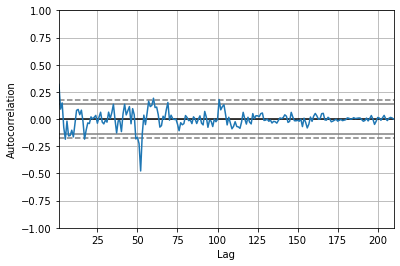

In [26]:
conso_nationale_hebdo_52 = conso_nationale_hebdo['Consommation (MW)'].diff(52).dropna()
pd.plotting.autocorrelation_plot(conso_nationale_hebdo_52);

In [27]:
sm.tsa.stattools.adfuller(conso_nationale_hebdo_52)

(-6.411756390005133,
 1.8832847636353557e-08,
 6,
 203,
 {'1%': -3.462980134086401,
  '5%': -2.875885461947131,
  '10%': -2.5744164898444515},
 3925.403313713601)

c:\Users\simon\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


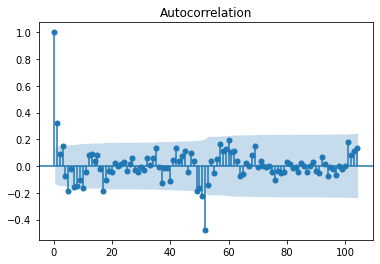

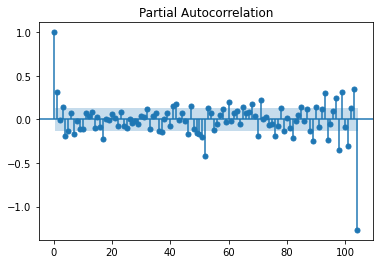

In [28]:
plot_acf(conso_nationale_hebdo_52, lags=104)
plot_pacf(conso_nationale_hebdo_52, lags=104);

In [29]:
sm.tsa.stattools.adfuller(conso_nationale_hebdo_52)

(-6.411756390005133,
 1.8832847636353557e-08,
 6,
 203,
 {'1%': -3.462980134086401,
  '5%': -2.875885461947131,
  '10%': -2.5744164898444515},
 3925.403313713601)

Le corrélogramme tend rapidement vers 0, et la p-value du test ADF est < 5%. la série semble stationnarisée.
<br>
Par ailleurs les deux corrélogrammes convergent tous les deux vers 0 : on semble être en présence d'un processus ARMA.

## Modélisation

In [32]:
# Modélisation
X_train = conso_nationale_hebdo[conso_nationale_hebdo.index<='2018-12-31']
X_test = conso_nationale_hebdo[conso_nationale_hebdo.index>'2018-12-31']

On essaye avec un auto_arima pour trouver le meilleur modèle.<br>
*Avec BIC comme critère, puis AIC.*

In [33]:
smodel = pm.auto_arima(
    X_train['Consommation (MW)'],
    xreg=X_train['temp'],
    test='adf',
    information_criterion='bic',
    max_p=4, 
    max_q=4,
    D=1,
    m=52,
    start_P=0,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

smodel.summary()

Performing stepwise search to minimize bic


KeyboardInterrupt: 

In [14]:
smodel = pm.auto_arima(
    X_train['Consommation (MW)'],
    xreg=X_train['temp'],
    test='adf',
    information_criterion='aic',
    max_p=2, 
    max_q=2,
    D=1,
    m=52,
    start_P=0,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

smodel.summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
# Modélisation avec le meilleur modèle déterminé par l'auto_arima
model = sm.tsa.SARIMAX(
    endog=X_train['Consommation (MW)'],
    order=(1, 0, 2),
    seasonal_order=(0, 1, 0, 52)
)

sarima = model.fit()
sarima.summary()

C:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   Consommation (MW)   No. Observations:                  262
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 52)   Log Likelihood               -2132.702
Date:                             Wed, 27 Apr 2022   AIC                           4273.403
Time:                                     21:10:48   BIC                           4286.792
Sample:                                          0   HQIC                          4278.816
                                             - 262                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7370      0.150      4.902      0.000       0.442       1.032
ma.L1         -0.4861      0.159     -3.066      0.002      -0.797      -0.175
ma.L2         -0.2276      0.038     -6.059      0.000      -0.301      -0.154
sigma2      3.718e+07   2.06e-09    1.8e+16      0.000    3.72e+07    3.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):                30.82
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.11
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.09e+31. Standard errors may be unstable.
"""

In [35]:
# Modélisation avec la température en variable exogène
model = sm.tsa.SARIMAX(
    endog=X_train['Consommation (MW)'],
    order=(1, 0, 2),
    seasonal_order=(0, 1, 0, 52),
    exog=X_train['temp']
)

sarima_avec_temp = model.fit()
sarima_avec_temp.summary()

c:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   Consommation (MW)   No. Observations:                  210
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1557.061
Date:                             Fri, 10 Jun 2022   AIC                           3124.122
Time:                                     13:43:39   BIC                           3139.435
Sample:                                          0   HQIC                          3130.341
                                             - 210                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp       -1131.0441     72.439    -15.614      0.000   -1273.022    -989.066
ar.L1          0.8651      0.196      4.403      0.000       0.480       1.250
ma.L1         -0.8083      0.228     -3.546      0.000      -1.255      -0.362
ma.L2         -0.0559      0.055     -1.013      0.311      -0.164       0.052
sigma2      2.096e+07      0.000   5.89e+10      0.000     2.1e+07     2.1e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.70   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.10   Prob(JB):                         0.92
Heteroskedasticity (H):               1.28   Skew:                            -0.08
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+26. Standard errors may be unstable.
"""

In [34]:
# Modélisation avec plusieurs variables exogènes
model = sm.tsa.SARIMAX(
    endog=X_train['Consommation (MW)'], 
    order=(1, 0, 2), 
    seasonal_order=(0, 1, 0, 52), 
    exog=X_train[['temp', 'humidite', 'nebulosite', 'vitesse_vent', 'pluie_24h']]
)
    
sarima_variables_exog = model.fit()
sarima_variables_exog.summary()

c:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\simon\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   Consommation (MW)   No. Observations:                  210
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1542.096
Date:                             Fri, 10 Jun 2022   AIC                           3102.192
Time:                                     13:43:35   BIC                           3129.755
Sample:                                          0   HQIC                          3113.386
                                             - 210                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp         -1163.9726     79.493    -14.643      0.000   -1319.775   -1008.170
humidite      -201.2733     58.565     -3.437      0.001    -316.059     -86.488
nebulosite      51.6521     38.643      1.337      0.181     -24.086     127.390
vitesse_vent  -126.0083    321.004     -0.393      0.695    -755.165     503.148
pluie_24h      -12.2357      6.951     -1.760      0.078     -25.860       1.388
ar.L1           -0.9550      0.084    -11.348      0.000      -1.120      -0.790
ma.L1            0.9565      0.097      9.875      0.000       0.767       1.146
ma.L2            0.0260      0.036      0.724      0.469      -0.044       0.096
sigma2        1.741e+07      0.004   4.12e+09      0.000    1.74e+07    1.74e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.76   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.02   Prob(JB):                         0.60
Heteroskedasticity (H):               1.23   Skew:                             0.20
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+25. Standard errors may be unstable.
"""

Les tests de Ljung-Box et Jarque-Bera sont concluants (les résidus forment un bruit blanc et suivent une loi normale).

## Prévisions

### Création de la séquence de température initiale

In [48]:
# df_rte_meteo = pd.read_csv(
#     'D:\\OneDrive\\Data Science\\Datascientest\\Py-wer\\Data\\rte_meteo_max_hebdo COPIE.csv',
#     sep=';',
#     decimal=',',
#     index_col=['Semaine']
# )

df_rte_meteo = pd.read_csv(
    'D:\\OneDrive\\Data_science\\Datascientest\\Py-wer\\Data\\rte_meteo_max_hebdo.csv',
    sep=';',
    decimal='.',
    index_col=['Date']
)

# df_temp_initiales = pd.DataFrame(df_rte_meteo.loc[df_rte_meteo.index>='2019-01', 'temp'])

# df_temp_initiales['year'] = df_temp_initiales.index.str[:4].astype(int)
# df_temp_initiales['week'] = df_temp_initiales.index.str[-2:].astype(int)
# dates = df_temp_initiales['year']*100 + df_temp_initiales['week']
# df_temp_initiales['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%G%V%w')
# df_temp_initiales = df_temp_initiales.set_index('Date')
# df_temp_initiales

df_temp_initiales = pd.DataFrame(df_rte_meteo.loc[df_rte_meteo.index>='2019-01', ['temp', 'humidite', 'nebulosite', 'vitesse_vent', 'pluie_24h']])
df_temp_initiales.index = pd.to_datetime(df_temp_initiales.index)
df_temp_initiales.head()

,temp,humidite,nebulosite,vitesse_vent,pluie_24h
Date,,,,,
2019-01-06,2.581703,78.528228,86.950824,3.043592,0.115385
2019-01-13,2.887555,75.747459,84.852679,3.660762,8.446154
2019-01-20,2.796401,80.622734,85.914698,2.935371,25.569231
2019-01-27,2.227809,78.989801,92.931490,3.497541,49.761538
2019-02-03,3.327799,81.145707,91.026889,4.762541,150.823077


c:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\Users\simon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


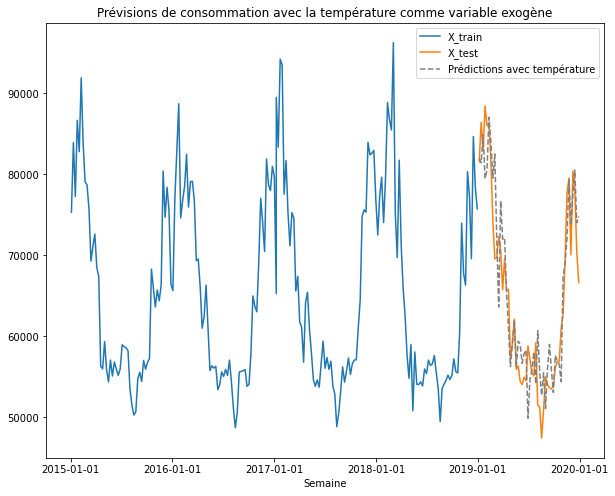

In [64]:
# Prévisions
# predictions_conso_nationale_hebdo = sarima.forecast(52)

predictions_conso_nationale_hebdo_temp = sarima_avec_temp.forecast(
    52, 
    exog=df_temp_initiales['temp']
)
predictions_conso_nationale_hebdo_temp = pd.DataFrame(predictions_conso_nationale_hebdo_temp)
predictions_conso_nationale_hebdo_temp.set_index(df_temp_initiales.index, inplace=True)


predictions_conso_nationale_hebdo_variables_exog = sarima_variables_exog.forecast(
    52, 
    exog=df_temp_initiales[['temp', 'humidite', 'nebulosite', 'vitesse_vent', 'pluie_24h']]
    )

predictions_conso_nationale_hebdo_variables_exog = pd.DataFrame(predictions_conso_nationale_hebdo_variables_exog)
predictions_conso_nationale_hebdo_variables_exog.set_index(df_temp_initiales.index, inplace=True)


# Graphique
plt.figure(figsize=(10, 8))
plt.plot(X_train['Consommation (MW)'], label='X_train')
plt.plot(X_test['Consommation (MW)'], label='X_test')

# plt.plot(
#     predictions_conso_nationale_hebdo, 
#     '--', 
#     label='Prédictions sans température', 
#     color='black'
# )   

plt.plot(
    predictions_conso_nationale_hebdo_temp, 
    '--', 
    label='Prédictions avec température', 
    color = 'gray'
)

# plt.plot(
#     predictions_conso_nationale_hebdo_variables_exog, 
#     '--', 
#     label='Prédictions plusieurs variables exog.', 
#     color = 'brown'
#     )

plt.legend()
plt.xticks(
    ['2015-01', '2016-01', '2017-01','2018-01', '2019-01', '2020-01']
)

plt.xlabel('Consommation (MW)')
plt.xlabel('Semaine')
plt.title('Prévisions de consommation avec la température comme variable exogène');

In [54]:
# error = rmse(predictions_conso_nationale_hebdo[:53], X_test['Consommation (MW)'])
error_avec_temp = rmse(predictions_conso_nationale_hebdo_temp['predicted_mean'][:53], X_test['Consommation (MW)'])
error_variables_exog = rmse(predictions_conso_nationale_hebdo_variables_exog['predicted_mean'][:53], X_test['Consommation (MW)'])

# print('Erreur sans température :', int(error))
print('RMSE avec température :', int(error_avec_temp))
print('RMSE avec plusieurs variables exog. :', int(error_variables_exog))

RMSE avec température : 4643
RMSE avec plusieurs variables exog. : 4931


In [55]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

mape(X_test['Consommation (MW)'], predictions_conso_nationale_hebdo_temp['predicted_mean'][:53])

0.05737068596754769

In [62]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

mape_temp = mape(X_test['Consommation (MW)'], predictions_conso_nationale_hebdo_temp['predicted_mean'][:53])
mape_temp = round(mape_temp, 3)

mape_variables_exog = mape(X_test['Consommation (MW)'], predictions_conso_nationale_hebdo_variables_exog['predicted_mean'][:53])
mape_variables_exog = round(mape_variables_exog, 3)

print('Erreur moyenne absolue avec température :', mape_temp)
print('Erreur moyenne absolue avec plusieurs variables exog :', mape_variables_exog)

Erreur moyenne absolue avec température : 0.057
Erreur moyenne absolue avec plusieurs variables exog : 0.064


# Ecriture du modèle

In [40]:
sarima_avec_temp.save('D:\\OneDrive\\Data_science\\Datascientest\\Py-wer\\conso_temp_st.pkl')